In [2]:
import os
from nltk.tag import StanfordNERTagger as NERTagger
from nltk.tag import StanfordPOSTagger as POSTagger
ner_jar = 'StanfordNLP/jars/stanford-ner.jar'
ner_model = 'StanfordNLP/models/english.all.3class.distsim.crf.ser.gz'
pos_jar = 'StanfordNLP/jars/stanford-postagger.jar'
pos_model = 'StanfordNLP/models/english-bidirectional-distsim.tagger'
ner_tagger = NERTagger(ner_model, ner_jar)
pos_tagger = POSTagger(pos_model, pos_jar)

把預處理過的每家公司的10-K財報資料製造成一個按詞頻遞減的list，再把這些list放到一個list中

In [3]:
import pickle
dic_freq = []
companies = ['AAPL', 'GOOG', 'MSFT', 'CSCO', 'FB']
for comp in companies:
    with open('pickles/{}/{}_2017.pickle'.format(comp, comp), 'rb') as f:
        dic_freq.append(pickle.load(f))
word_list = []
for dic in dic_freq:
    word_list.append([i[0] for i in dic])
for wl in word_list:
    print(wl[:20])

['the', 'and', 'Company', 'The', 'for', 'any', 'that', 'with', 'are', 'its', 'may', 'other', 'Plan', 'Stock', 'such', 'not', 'shall', 'under', 'Participant', 'Award']
['and', 'the', 'our', 'for', 'are', 'that', 'from', 'revenues', 'other', 'Google', 'December', 'The', 'with', 'have', 'income', 'not', 'Alphabet', 'may', 'tax', 'net']
['and', 'the', 'our', 'for', 'revenue', 'are', 'that', 'with', 'billion', 'from', 'services', 'The', 'income', 'other', 'products', 'June', 'year', 'may', 'million', 'business']
['the', 'and', 'Company', 'any', 'for', 'Stock', 'that', 'with', 'Units', 'shall', 'our', 'you', 'are', 'this', 'The', 'your', 'may', 'other', 'Plan', 'Restricted']
['and', 'the', 'our', 'that', 'for', 'are', 'may', 'other', 'with', 'tax', 'from', 'products', 'not', 'have', 'financial', 'December', 'which', 'revenue', 'such', 'The']


用ner把這些詞分類至organization, location, person這三個類別

In [4]:
org_list = []
org_set = set()
loc_list = []
loc_set = set()
per_list = []
per_set = set()
for wl in word_list:
    dic_ner = dict(ner_tagger.tag(wl))
    org_list.append([])
    loc_list.append([])
    per_list.append([])
    for word, ner in dic_ner.items():
        if len(word) < 3:
            continue
        if ner == 'ORGANIZATION':
            org_list[-1].append(word)
            org_set.add(word)
        if ner == 'LOCATION':
            loc_list[-1].append(word)
            loc_set.add(word)
        if ner == 'PERSON':
            per_list[-1].append(word)
            per_set.add(word)
print(list(org_set)[:20])
print(list(loc_set)[:20])
print(list(per_set)[:20])

['ETA', 'Sciences', 'Voxeo', 'Fixed', 'ADMINISTRATION', 'Iran', 'Since', 'Hungary', 'COMMISSION', 'Renting', 'CIO', 'CADE', 'Worldwide', 'McGraw', 'Chile', 'Arris', 'Scotland', 'Amsterdam', 'VSOE', 'SAS']
['Poland', 'Santa', 'Vietnam', 'Kong', 'Iran', 'States', 'Road', 'Spain', 'Sao', 'Clara', 'Alto', 'Silicon', 'Sirketi', 'District', 'Japan', 'America', 'Fort', 'Hong', 'Northern', 'California']
['Peter', 'Carol', 'Ronald', 'Eric', 'Pankaj', 'Gary', 'RUTH', 'Bradford', 'Wagner', 'BlackRock', 'Kristina', 'Gates', 'Bowles', 'Patel', 'Cox', 'Peterson', 'Prat', 'MaintenanceNet', 'Brin', 'JOHN']


用pos把這些詞按照詞性分類，而我們只使用形容詞

In [5]:
adj_list = []
adj_set = set()
for wl in word_list:
    dic_pos = dict(pos_tagger.tag(wl[:200]))
    adj_list.append([])
    for word, pos in dic_pos.items():
        if len(word) < 3:
            continue
        if pos == 'JJ':
            adj_list[-1].append(word)
            adj_set.add(word)
print(list(adj_set)[:20])

['right', 'Tax-Related', 'regulatory', 'subject', 'outstanding', 'prior', 'due', 'local', 'fiscal', 'affected', 'financial', 'total', 'third-party', 'marketable', 'current', 'pursuant', '10-K', 'control', 'standard', 'necessary']


organization類別的matrix

In [6]:
import numpy as np
import pandas as pd
org_matrix = np.array([[(dict(dic)[word] if word in dict(dic) else 0) for word in org_set] for dic in dic_freq])
org_matrix = pd.DataFrame(org_matrix, columns = org_set, index = companies)
org_matrix

,ETA,Sciences,Voxeo,Fixed,ADMINISTRATION,Iran,Since,Hungary,COMMISSION,Renting,...,Laboratories,SCH,Trial,ParStream,Ehf,Recognition,Geographic,LLC,SBC,India
AAPL,0,0,0,8,1,0,0,0,1,0,...,0,1,0,0,0,5,5,10,0,3
GOOG,0,0,0,4,0,0,2,0,1,0,...,0,1,0,0,0,3,1,3,11,1
MSFT,0,0,0,1,0,1,3,0,1,0,...,0,1,1,0,0,4,3,0,0,4
CSCO,2,1,1,17,2,0,1,3,1,1,...,1,1,2,1,1,5,0,58,0,48
FB,0,0,0,0,0,1,3,0,1,0,...,0,1,2,0,0,1,1,3,0,6


person類別的matrix

In [7]:
per_matrix = np.array([[(dict(dic)[word] if word in dict(dic) else 0) for word in per_set] for dic in dic_freq])
per_matrix = pd.DataFrame(per_matrix, columns = per_set, index = companies)
per_matrix

,Peter,Carol,Ronald,Eric,Pankaj,Gary,RUTH,Bradford,Wagner,BlackRock,...,SUSAN,PORAT,Iger,Larry,Saunders,Capitalized,Frank,MULALLY,Hennessy,Chris
AAPL,0,0,1,0,0,0,0,0,1,0,...,1,0,1,0,0,4,0,0,0,1
GOOG,0,0,0,7,0,0,3,0,0,0,...,0,3,0,15,0,2,0,1,1,0
MSFT,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,3,0,0,0
CSCO,0,1,0,0,1,1,0,0,0,1,...,0,0,0,0,1,2,0,0,1,2
FB,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0


location類別的matrix

In [8]:
enm = list(enumerate(loc_set))
for i, word in enm:
    if i >= 50:
        loc_set.remove(word)
loc_matrix = np.array([[(dict(dic)[word] if word in dict(dic) else 0) for word in loc_set] for dic in dic_freq])
loc_matrix = pd.DataFrame(loc_matrix, columns = loc_set, index = companies)
loc_matrix

,Poland,Santa,Vietnam,Kong,Iran,States,Road,Spain,Sao,Clara,...,Delaware,New,Austria,San,Arabia,Symantec,East,London,Chengdu,Italy
AAPL,0,2,0,4,0,9,0,0,0,2,...,0,9,0,4,0,0,3,0,0,0
GOOG,0,0,0,0,0,14,0,0,0,0,...,11,4,0,3,0,0,1,0,0,0
MSFT,0,0,1,0,1,15,0,0,0,0,...,4,34,1,0,0,0,2,0,1,0
CSCO,4,2,3,6,0,92,0,6,5,2,...,48,13,3,8,4,1,5,1,0,9
FB,0,0,3,0,1,43,2,0,0,0,...,8,3,0,3,0,0,1,0,0,0


形容詞詞性類別的matrix，其中把大量出現但無意義的other和such先刪掉

In [9]:
unimportant = ['Other', 'other', 'such', 'such']
for word in unimportant:
    if word in adj_set:
        adj_set.remove(word)
#enm = list(enumerate(adj_set))
#for i, word in enm:
 #   if i >= 30:
  #      adj_set.remove(word)
adj_matrix = np.array([[(dict(dic)[word] if word in dict(dic) else 0) for word in adj_set] for dic in dic_freq])
adj_df = pd.DataFrame(adj_matrix, columns = adj_set, index = companies)
adj_df

,right,Tax-Related,regulatory,subject,outstanding,prior,due,local,fiscal,affected,...,available,fair,certain,share-based,net,Performance-Based,used,Annual,Ended,Net
AAPL,35,24,1,171,64,40,133,12,30,33,...,57,67,72,11,203,0,50,12,1,48
GOOG,10,0,14,56,35,15,70,7,12,22,...,25,65,101,0,165,0,41,41,44,49
MSFT,2,0,16,38,15,14,150,13,136,15,...,37,101,60,0,86,0,37,2,38,43
CSCO,105,150,26,282,178,106,118,136,326,46,...,49,150,172,34,136,294,69,49,40,54
FB,0,0,32,71,28,10,59,7,8,37,...,26,41,72,42,95,0,39,36,30,40


形容詞詞性vs形容詞詞性的co-occurence matrix

In [13]:
def my_log(x):
    return np.log(x + 1)
adj_comatrix = np.matmul(np.transpose(adj_matrix), adj_matrix)
adj_norm = np.vectorize(my_log)(adj_comatrix)
adj_norm /= adj_norm.max(axis = None)
adj_comatrix = pd.DataFrame(adj_comatrix, columns = adj_set, index = adj_set)
adj_norm = pd.DataFrame(adj_norm, columns = adj_set, index = adj_set)
adj_comatrix.to_csv('adj_comatrix.csv')
adj_comatrix

,right,Tax-Related,regulatory,subject,outstanding,prior,due,local,fiscal,affected,...,available,fair,certain,share-based,net,Performance-Based,used,Annual,Ended,Net
right,12354,16590,2937,36231,21310,12708,18045,14796,35672,6235,...,7464,18947,21710,3955,23207,30870,9479,5979,4751,7926
Tax-Related,16590,23076,3924,46404,28236,16860,20892,20688,49620,7692,...,8718,24108,27528,5364,25272,44100,11550,7638,6024,9252
regulatory,2937,3924,2153,11167,6318,3550,8469,4078,11106,2961,...,3105,7805,9222,2239,10465,7644,4258,3044,3225,4106
subject,36231,46404,11167,118386,65658,38814,69828,41787,103470,23044,...,28217,64146,73864,14451,92318,82908,34479,20798,17489,30654
outstanding,21310,28236,6318,65658,38014,22443,35868,25612,62632,12331,...,14528,35926,41675,7932,46925,52332,18564,11963,10134,16164
prior,12708,16860,3550,38814,22443,13357,21568,15253,37920,7106,...,8627,21379,24187,4464,27165,31164,10837,6677,5772,9381
due,18045,20892,8469,69828,35868,21568,62494,20497,64170,15790,...,22197,48730,50190,7953,73102,34692,25513,12672,15403,24996
local,14796,20688,4078,41787,25612,15253,20497,18907,46604,7260,...,8186,23259,26247,5050,23870,39984,11025,7373,6464,9102
fiscal,35672,49620,11106,103470,62632,37920,64170,46604,125880,18586,...,23224,65754,68180,11750,64862,95844,29830,17386,19006,25800
affected,6235,7692,2961,23044,12331,7106,15790,7260,18586,5283,...,6202,13573,16074,3481,21390,13524,7724,4914,4521,7271


用gephi畫出的共現圖
![Alt text](adjective_coocurrence.png)

用seaborn套件畫出的熱點圖，為了提升視覺效果，使用的矩陣先取了對數後標準化至0到1的區間。

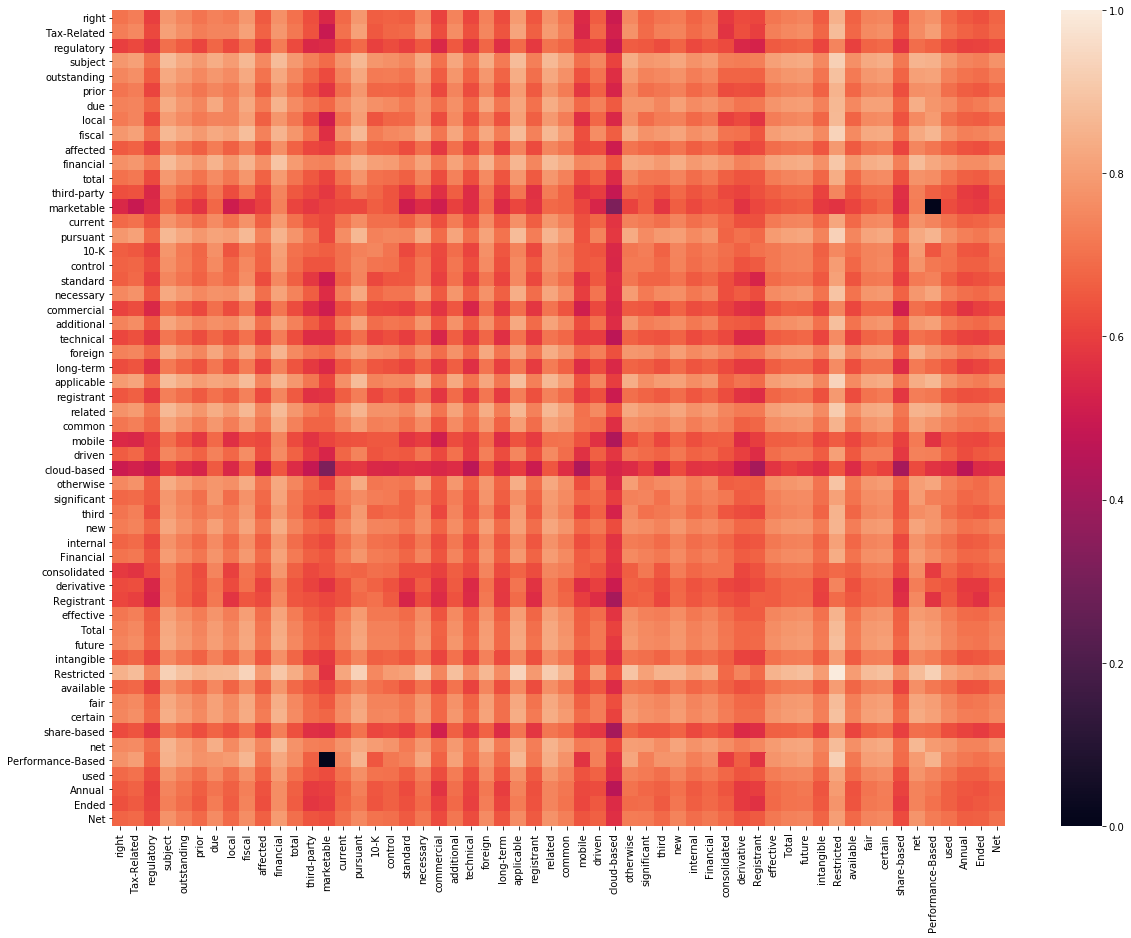

In [16]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.subplots(figsize=(20,15))
sn.heatmap(adj_norm)
plt.show()

location vs location的co-occurence matrix

In [17]:
loc_comatrix = np.matmul(np.transpose(loc_matrix), loc_matrix)
loc_norm = np.vectorize(my_log)(loc_comatrix)
loc_norm /= loc_norm.max(axis = None)
loc_comatrix = pd.DataFrame(loc_comatrix, columns = loc_set, index = loc_set)
loc_norm = pd.DataFrame(loc_norm, columns = loc_set, index = loc_set)
loc_comatrix.to_csv('loc_comatrix.csv')
loc_comatrix

,Poland,Santa,Vietnam,Kong,Iran,States,Road,Spain,Sao,Clara,...,Delaware,New,Austria,San,Arabia,Symantec,East,London,Chengdu,Italy
Poland,16,8,12,24,0,368,0,24,20,8,...,192,52,12,32,16,4,20,4,0,36
Santa,8,8,6,20,0,202,0,12,10,8,...,96,44,6,24,8,2,16,2,0,18
Vietnam,12,6,19,18,4,420,6,18,15,6,...,172,82,10,33,12,3,20,3,1,27
Kong,24,20,18,52,0,588,0,36,30,20,...,288,114,18,64,24,6,42,6,0,54
Iran,0,0,4,0,2,58,2,0,0,0,...,12,37,1,3,0,0,3,0,1,0
States,368,202,420,588,58,10815,86,552,460,202,...,4974,1972,291,943,368,92,574,92,15,828
Road,0,0,6,0,2,86,4,0,0,0,...,16,6,0,6,0,0,2,0,0,0
Spain,24,12,18,36,0,552,0,36,30,12,...,288,78,18,48,24,6,30,6,0,54
Sao,20,10,15,30,0,460,0,30,25,10,...,240,65,15,40,20,5,25,5,0,45
Clara,8,8,6,20,0,202,0,12,10,8,...,96,44,6,24,8,2,16,2,0,18


用gephi畫出的共現圖
![Alt text](location_coocurrence.png)

用seaborn套件畫出的熱點圖，為了提升視覺效果，使用的矩陣先取了對數後標準化至0到1的區間。

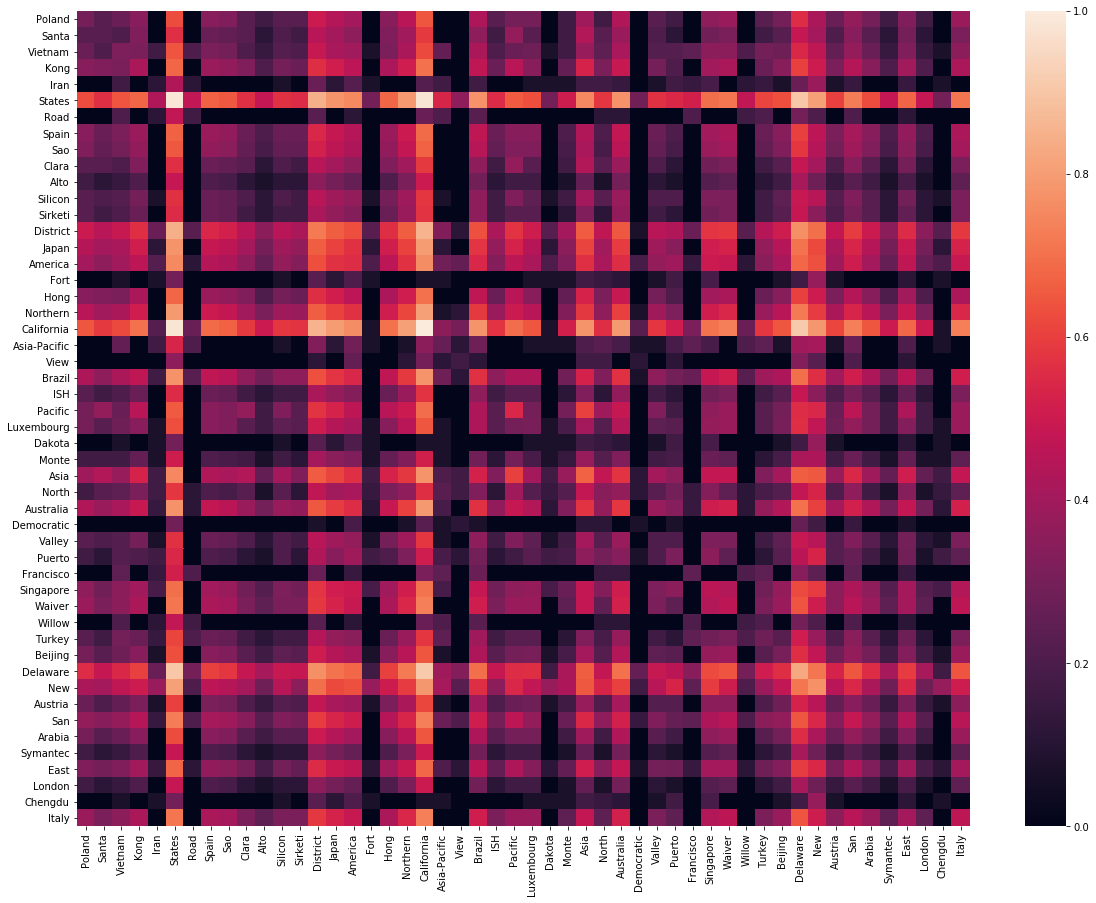

In [18]:
plt.subplots(figsize=(20,15))
sn.heatmap(loc_norm)
plt.show()